IRSA Explainer: https://wise2.ipac.caltech.edu/docs/release/allwise/expsup/sec2_1a.html

Stars within 100 pc of the Sun:  https://www.aanda.org/articles/aa/full_html/2021/05/aa39498-20/aa39498-20.html

LAMOST data cleaning procedure: https://iopscience.iop.org/article/10.3847/1538-4357/acaf5a/pdf
        

In [1]:
from astropy.io import fits
from astropy.table import Table, join, unique

from astropy.coordinates import SkyCoord
import astropy.units as u

from astropy.utils.metadata import merge

import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt


from multiprocessing import set_start_method

plt.style.use('stefan.mplstyle')

In [2]:
catalog = Table.read('data/all_wds.csv')
references = pd.read_csv('data/table_irsa_catalog_search_results.csv')
references = references.apply(pd.to_numeric, errors = 'ignore')
references = Table.from_pandas(references)

# Stars from Gaia selected to be within 100pc of the Sun
# source: https://www.aanda.org/articles/aa/full_html/2021/05/aa39498-20/aa39498-20.html
allstars = Table.read('data/allstars.dat.gz', format='ipac')

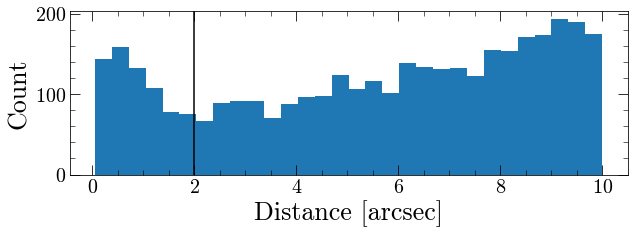

In [3]:
plt.figure(figsize = (10,3))
plt.hist(references['dist_x'], bins = 30)
plt.axvline(x = 2, c = 'k')
plt.xlabel('Distance [arcsec]')
plt.ylabel('Count')

references = references[references['dist_x'] < 2]

In [4]:
catalog = join(left=catalog, right=references, keys_left='CATALOGID', keys_right='catalogid_01', join_type="inner")

(array([ 64., 108.,  90.,  78.,  87.,  62.,  50.,  24.,  25.,  16.,  15.,
          6.,   9.,   8.,   5.,   5.,   3.,   8.,   2.,   2.,   1.,   1.,
          2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   1.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   1.]),
 array([ 0.56857198,  2.2074055 ,  3.84623901,  5.48507253,  7.12390604,
         8.76273956, 10.40157307, 12.04040658, 13.6792401 , 15.31807361,
        16.95690713, 18.59574064, 20.23457416, 21.87340767, 23.51224118,
        25.1510747 , 26.78990821, 28.42874173, 30.06757524, 31.70640876,
        33.34524227, 34.98407578, 36.6229093 , 38.26174281, 39.90057633,
        41.53940984, 43.17824336, 44.81707687, 46.45591038, 48.0947439 ,
        49.73357741, 51.37241093, 53.01124444, 54.65007796, 56.28891147,
        57.92774498, 59.5665785 , 61.20541201, 62.84424553, 64.48307904,
        66.12191256, 67.76074607, 69.39957958, 71.0384131 , 72.67724661,
       

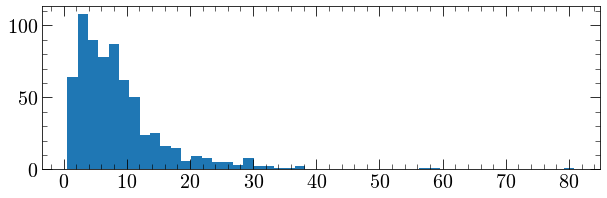

In [5]:
plt.figure(figsize=(10,3))
plt.hist(catalog['PARALLAX'])

In [6]:
from __future__ import print_function
from astropy.coordinates import SkyCoord
import astropy.units as u
from dustmaps.edenhofer2023 import Edenhofer2023Query

import pyphot
import extinction

catalog['r_med_geo'] = 100 / catalog['PARALLAX']

# Coordinates using inverted parallax distances
coords = [SkyCoord(frame="icrs", ra=catalog['RA'][i]*u.deg, dec=catalog['DEC'][i]*u.deg, distance = catalog['r_med_geo'][i] * u.pc) for i in range(len(catalog))]
catalog['wd_coords'] = coords


# Query Edenhofer2023 to get E(B-V) in arbitrary units
bsq = Edenhofer2023Query()
bsq_res = bsq.query(catalog['wd_coords']).copy()
bsq_res[np.isnan(bsq_res)] = 0

# Convert to actual units
Ebv = bsq_res*0.901*0.98
e_Ebv = Ebv*0.2

catalog['E(B-V)'] = Ebv
catalog['e_E(B-V)'] = e_Ebv


# Parameters for correcting using Gaia
Rv = 3.1
catalog['A_v0'] = catalog['E(B-V)']*Rv

# Fetch Gaia photometric band wavelengths and store in `gaia_phot_wavl`
lib = pyphot.get_library()
gaia_phot = [lib['Gaia_G'], lib['Gaia_BP'], lib['Gaia_RP']]
gaia_phot_wavl = np.array([x.lpivot.to('angstrom').value for x in gaia_phot])


# For each point, find extinction using the parameters we defined above
ext_all = []
for av0 in catalog['A_v0']:
    ext_all.append( extinction.fitzpatrick99(gaia_phot_wavl, av0, Rv) )
ext_all = np.array(ext_all)
    
# Save the extinction in each band
catalog['BP_ext'] = ext_all.T[0]
catalog['RP_ext'] = ext_all.T[1]

# Subtract out the extinction to find de-reddened magnitude
catalog['GAIA_G'] = catalog['GAIA_G'] - catalog['BP_ext']
catalog['GAIA_BP'] = catalog['GAIA_BP'] - catalog['BP_ext']
catalog['GAIA_RP'] = catalog['GAIA_RP'] - catalog['RP_ext']

Optimizing map for querying (this might take a couple of seconds)...


In [7]:
catalog['abs_g'] = catalog['GAIA_G'] + 5 * np.log10(catalog['PARALLAX'] / 100)
catalog['abs_bp'] = catalog['GAIA_BP'] + 5 * np.log10(catalog['PARALLAX'] / 100)
catalog['abs_rp'] = catalog['GAIA_RP'] + 5 * np.log10(catalog['PARALLAX'] / 100)

catalog['bp_rp'] = catalog['abs_bp'] - catalog['abs_rp']

catalog['abs_w1'] = catalog['w1mpro'] + 5 * np.log10(catalog['PARALLAX'] / 100)
catalog['abs_w2'] = catalog['w2mpro'] + 5 * np.log10(catalog['PARALLAX'] / 100)
catalog['abs_w3'] = catalog['w3mpro'] + 5 * np.log10(catalog['PARALLAX'] / 100)
#catalog['abs_w4'] = catalog['w4mpro'] + 5 * np.log10(catalog['PARALLAX'] / 100)

catalog['distance'] = 100 / catalog['PARALLAX']

<ipython-input-7-7e9a4ef1b0a7>:1: RuntimeWarning: divide by zero encountered in log10
  catalog['abs_g'] = catalog['GAIA_G'] + 5 * np.log10(catalog['PARALLAX'] / 100)
<ipython-input-7-7e9a4ef1b0a7>:2: RuntimeWarning: divide by zero encountered in log10
  catalog['abs_bp'] = catalog['GAIA_BP'] + 5 * np.log10(catalog['PARALLAX'] / 100)
<ipython-input-7-7e9a4ef1b0a7>:3: RuntimeWarning: divide by zero encountered in log10
  catalog['abs_rp'] = catalog['GAIA_RP'] + 5 * np.log10(catalog['PARALLAX'] / 100)
<ipython-input-7-7e9a4ef1b0a7>:7: RuntimeWarning: divide by zero encountered in log10
  catalog['abs_w1'] = catalog['w1mpro'] + 5 * np.log10(catalog['PARALLAX'] / 100)
<ipython-input-7-7e9a4ef1b0a7>:8: RuntimeWarning: divide by zero encountered in log10
  catalog['abs_w2'] = catalog['w2mpro'] + 5 * np.log10(catalog['PARALLAX'] / 100)
<ipython-input-7-7e9a4ef1b0a7>:9: RuntimeWarning: divide by zero encountered in log10
  catalog['abs_w3'] = catalog['w3mpro'] + 5 * np.log10(catalog['PARALLAX'

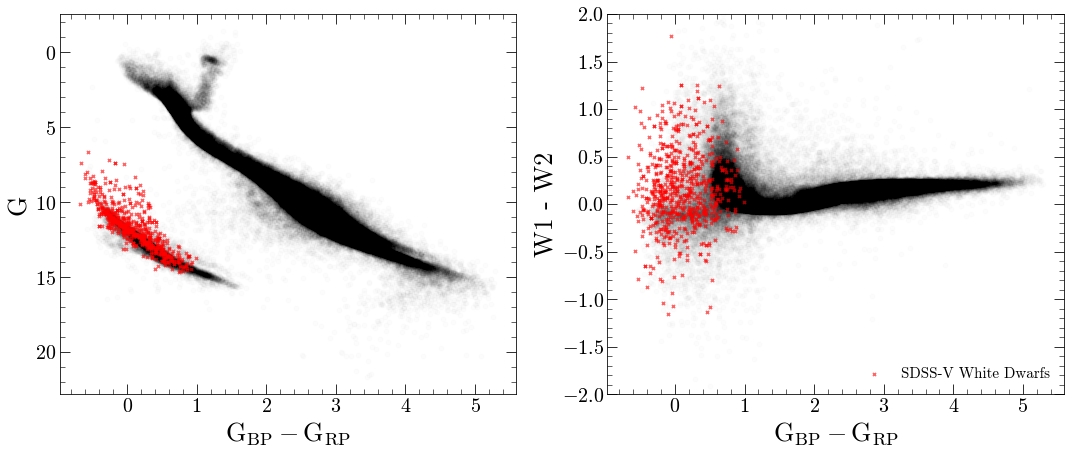

In [8]:
plt.figure(figsize=(18,7))

plt.subplot(1,2,1)

plt.scatter(allstars['abs_bp'] - allstars['abs_rp'], allstars['abs_g'], c = 'k', alpha = 0.01)
plt.scatter(catalog['abs_bp'] - catalog['abs_rp'], catalog['abs_g'],  c = 'red', alpha = 0.6, marker = 'x', s = 10, label = 'SDSS-V White Dwarfs')

plt.xlabel(r'$G_{BP} - G_{RP}$')
plt.ylabel('G')
plt.gca().invert_yaxis()

plt.subplot(1,2,2)

plt.scatter(allstars['abs_bp'] - allstars['abs_rp'], allstars['abs_w1'] - allstars['abs_w2'], c = 'k', alpha = 0.01)
plt.scatter(catalog['abs_bp'] - catalog['abs_rp'], catalog['abs_w1'] - catalog['abs_w2'], c = 'red', alpha = 0.6, marker = 'x', s = 10, label = 'SDSS-V White Dwarfs')

plt.legend(framealpha = 0)

plt.ylim(-2,2)

plt.xlabel(r'$G_{BP} - G_{RP}$')
plt.ylabel('W1 - W2')

plt.savefig('plots/wise_cmd.pdf')

In [9]:
import sys
sys.path.append('../corv/src')

import pyphot
from pyphot import unit
import corv
import lmfit

base_wavl, tremblay, table = corv.utils.build_montreal_da(path = '/home/sarsene1/corv/src/corv/models/montreal_da', flux_unit = 'flam')

lib = pyphot.get_library()
filters = [lib['Gaia_BP'], lib['Gaia_RP']]

c = 2.998e10
k = 1.38e-16
h = 6.626e-27
halpha = 6564.61
hbeta = 4862.68
hgamma = 4341.68
hdelta = 4102.89
speed_light = 299792458 #m/s
mass_sun = 1.9884e30
newton_G = 6.674e-11
pc_to_m = 3.086775e16
radius_sun = 6.957e8

def mag_to_flux_spec(mag, filt, e_mag = None):
    if e_mag is not None:
        return (10**( (mag + filt.Vega_zero_mag) / -2.5 ), np.sqrt((-0.921034 * 10**(-0.4 * (mag + filt.Vega_zero_mag)) * e_mag)**2 ))
    else:
        return 10**( (mag + filt.Vega_zero_mag) / -2.5 )

def template(teff, logg, radius, distance):
    fl = tremblay((teff, logg))
    
    radius = radius * radius_sun # Rsun to meter
    distance = distance * pc_to_m # Parsec to meter
    
    fl = 4*np.pi*(radius / distance)**2 * fl
    return fl
    

def get_model_flux_gaia_spec(params):
    teff, logg, radius, distance = params['teff'], params['logg'], params['radius'], params['distance']
    
    fl = template(teff, logg, radius, distance) 
            
    flux = np.array([filters[i].get_flux(base_wavl * unit['angstrom'], fl * unit['erg/s/cm**2/angstrom'], axis = 1).to('erg/s/cm**2/angstrom').value for i in range(len(filters))])
    #mag = np.array([-2.5*np.log10(filters[i].get_flux(base_wavl * unit['AA'], fl * unit['erg/s/cm**2/AA'], axis = 1).value) - filters[i].Vega_zero_mag for i in range(len(filters))])
    return flux
    

def residual_gaia(params, obs_flux = None, e_obs_flux = None):
    model_flux = get_model_flux_gaia_spec(params)
    chisquare = (model_flux - obs_flux)**2
    
    #chisquare[np.isnan(chisquare)] = 1e8
    return chisquare

def get_parameters_gaia(obs_flux, id_ = None, floor_error = 0.02, make_plot = False, vary_logg = False, p0 = [10000, 8, 0.01, 100]):         
    params = lmfit.Parameters()

    params.add('teff', value = p0[0], min = 4001, max = 80000, vary = True)
    params.add('logg', value = p0[1], min=5, max=9, vary=False)
    params.add('radius', value = p0[2], min = 0.000001, max = 0.05, vary = True)
    params.add('distance', value = p0[3], min = 1, max = 2000, vary = False)
            
    result = lmfit.minimize(residual_gaia, params, kws = dict(obs_flux = obs_flux), method = 'nedler')
            
    return result

building montreal da model
could not find pickled WD models
/Users/vedantchandra/0_research/01_sdss5/006_build_corv/data/comm_cat/
star and exposure catalogs not found! check paths and run make_catalogs() if you want to use sdss functionality. otherwise ignore.


In [10]:
teff = []
logg = []
radius = []
drops = []

for i in tqdm(range(len(catalog))):
    obs_flux = [#mag_to_flux_spec(catalog['abs_g'][i], filters[0]),
                mag_to_flux_spec(catalog['abs_bp'][i], filters[0]), 
                mag_to_flux_spec(catalog['abs_rp'][i], filters[1])]
    
    try:
        temp = get_parameters_gaia(obs_flux, p0 = [catalog['Teff_SnowWhite'][i], catalog['Logg_SnowWhite'][i], 0.01, catalog['distance'][i]])
    
        teff.append(temp.params['teff'].value)
        logg.append(temp.params['logg'].value)
        radius.append(temp.params['radius'].value)
    except:
        drops.append(i)
    
catalog.remove_rows(drops)
catalog['fit_teff'] = teff
catalog['fit_logg'] = logg
catalog['fit_radius'] = radius

 10%|█         | 69/681 [00:45<05:38,  1.81it/s]/home/sarsene1/.local/lib/python3.8/site-packages/scipy/optimize/_minimize.py:496: UserWarning: Warning: converting a masked element to nan.
  x0 = np.asarray(x0)
/home/sarsene1/.local/lib/python3.8/site-packages/lmfit/parameter.py:930: UserWarning: Warning: converting a masked element to nan.
  return array(float(self._getval()))
 33%|███▎      | 223/681 [02:06<03:52,  1.97it/s]<ipython-input-9-3b5d80479611>:39: RuntimeWarning: divide by zero encountered in true_divide
  fl = 4*np.pi*(radius / distance)**2 * fl
100%|██████████| 681/681 [06:24<00:00,  1.77it/s]


In [21]:
lib = pyphot.get_library()
filt_full = [lib['Gaia_G'], lib['Gaia_BP'], lib['Gaia_RP'], lib['WISE_RSR_W1'], lib['WISE_RSR_W2']]

w1_dists = []
w2_dists = []

id_ = []

for i in tqdm(range(len(catalog))):
    fl = 4 * np.pi *tremblay((catalog['fit_teff'][i], catalog['fit_logg'][i])) * ( (catalog['fit_radius'][i] * radius_sun) / (catalog['distance'][i] * pc_to_m)) **2
    
    wavl = [filt_full[i].lpivot.to('angstrom').value for i in range(len(filt_full))]
    phot_flux = [filt_full[i].get_flux(base_wavl * unit['AA'], fl * unit['erg/s/cm**2/AA'], axis = 1).value for i in range(len(filt_full))]
    phot_mag = np.array([-2.5*np.log10(filt_full[i].get_flux(base_wavl * unit['AA'], fl * unit['erg/s/cm**2/AA'], axis = 1).value) \
                         - filt_full[i].Vega_zero_mag for i in range(len(filt_full))])
    
    obs_flux = np.array([mag_to_flux_spec(catalog['abs_g'][i], filt_full[0]),
                        mag_to_flux_spec(catalog['abs_bp'][i], filt_full[1]),
                        mag_to_flux_spec(catalog['abs_rp'][i], filt_full[2]),
                        mag_to_flux_spec(catalog['abs_w1'][i], filt_full[3]),
                        mag_to_flux_spec(catalog['abs_w2'][i], filt_full[4])])
    
    
    e_w1 = obs_flux[-2] * 1.09 * catalog['w1sigmpro'][i]
    e_w2 = obs_flux[-1] * 1.09 * catalog['w2sigmpro'][i]
    w1_dist = (obs_flux[-2] - phot_flux[-2]) / e_w1
    w2_dist = (obs_flux[-1] - phot_flux[-1]) / e_w2
    
    w1_dists.append(w1_dist)
    w2_dists.append(w2_dist)
    id_.append(i)
    
    plt.figure(figsize=(18,7))
    
    plt.subplot(1,2,1)
    
    mask1 = (3600 < base_wavl) * (base_wavl < 9000)
    
    plt.plot(base_wavl[mask1], fl[mask1], c = 'k')
    plt.scatter([filt_full[j].lpivot.to('angstrom').value for j in range(len(filt_full))][:2], obs_flux[:2], c = 'k')
    plt.scatter(wavl[:2], phot_flux[:2], c = 'r', alpha = 0.7)
    
    plt.text(0.05, 0.20, "$T_{eff}$" + " = {:2.6} $K$".format(catalog['fit_teff'][i]), transform = plt.gca().transAxes, fontsize = 18)
    plt.text(0.05, 0.15, "$\log g$" + " = {:2.5f}".format(catalog['fit_logg'][i]), transform = plt.gca().transAxes, fontsize = 18)
    plt.text(0.05, 0.05, '$Distance = ${:2.1f} $pc$'.format(catalog['distance'][i]), transform = plt.gca().transAxes, fontsize=18)
    plt.text(0.05, 0.10, r'$Radius = ${:2.5f} $R_\odot$'.format(catalog['fit_radius'][i]), transform = plt.gca().transAxes, fontsize = 18)
    
    #plt.ylim(0.7*min(fl), 1.3*max(fl))
    
    plt.xlim((3600, 9000))
    plt.xlabel(r'Wavelength $[\AA]$')
    plt.ylabel('Flux $[erg/s/cm^2/\AA]$')
    
    plt.subplot(1,2,2)
    
    mask2 = (30000 < base_wavl) * (base_wavl < 50000)
    
    plt.plot(base_wavl, fl, c = 'k')
    plt.scatter([filt_full[j].lpivot.to('angstrom').value for j in range(len(filt_full))], obs_flux, c = 'k')
    plt.scatter(wavl, phot_flux, c = 'r')
    
    plt.text(0.05, 0.15, "$W1$ Distance" + " = {:2.2}".format(w1_dist), transform = plt.gca().transAxes, fontsize = 18)
    plt.text(0.05, 0.10, "$W2$ Distance" + " = {:2.2}".format(w2_dist), transform = plt.gca().transAxes, fontsize = 18)
    
    plt.yscale('log')
    plt.xlim(2500,50000)
    plt.xlabel(r'Wavelength $[\AA]$')
    plt.ylabel(r'Flux $[erg/s/cm^2/\AA]$')

    plt.savefig('plots/sed_fits/{}_sedfit.png'.format(i))
    
    plt.close()
    
catalog['id'] = id_
catalog['w1_dist'] = w1_dists
catalog['w2_dist'] = w2_dists

  0%|          | 1/643 [00:01<17:40,  1.65s/it]<ipython-input-21-c6638e3d4790>:27: RuntimeWarning: divide by zero encountered in true_divide
  w2_dist = (obs_flux[-1] - phot_flux[-1]) / e_w2
<ipython-input-21-c6638e3d4790>:63: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  plt.text(0.05, 0.10, "$W2$ Distance" + " = {:2.2}".format(w2_dist), transform = plt.gca().transAxes, fontsize = 18)
 33%|███▎      | 214/643 [05:57<11:38,  1.63s/it] <ipython-input-21-c6638e3d4790>:26: RuntimeWarning: divide by zero encountered in true_divide
  w1_dist = (obs_flux[-2] - phot_flux[-2]) / e_w1
<ipython-input-21-c6638e3d4790>:62: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  plt.text(0.05, 0.15, "$W1$ Distance" + " = {:2.2}".format(w1_dist), transform = plt.gca().transAxes, fontsize = 18)
100%|██████████| 643/643 [17:40<00:00,  1.65s/it]


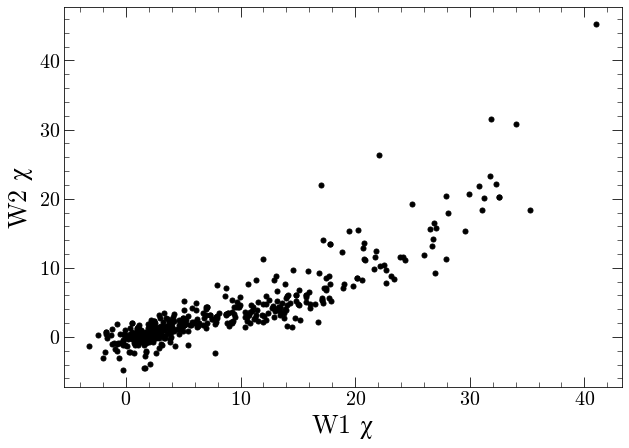

In [22]:
plt.figure(figsize = (10,7))

plt.scatter(catalog['w1_dist'], catalog['w2_dist'], c = 'k')

plt.xlabel(r'W1 $\chi$')
plt.ylabel(r'W2 $\chi$')

#plt.xlim(-0.01e-14, 0.15e-14)
#plt.ylim(-0.01e-15, 0.5e-15)

plt.savefig('plots/WISE_discrepancy.pdf')

In [80]:
mask = np.all([catalog['w1_dist'] > 3, catalog['w2_dist'] > 3], axis = 0)

print(catalog[mask][['ra', 'dec']])

        ra                 dec        
------------------ -------------------
       303.1013292          56.0145358
       285.7940952  57.158282299999996
284.79918399999997   57.27219010000001
       248.3280911  43.397400899999994
       243.3680631          54.3449926
242.51677259999997          56.2306777
253.68462590000001   72.35835949999999
       262.6027773   77.30275040000001
       187.9811571          63.2600073
        222.527239          40.9260187
               ...                 ...
       310.5689831 -1.7159168999999999
       310.0320365 -0.5392531999999999
       311.6840425 -1.9120028000000002
       312.0587609          -1.6575879
       260.9568986   4.979463900000001
       290.9974059  21.684247199999998
       299.8259006           5.8058027
        306.463759           0.6653916
       306.1479257  1.7507077000000002
       307.7296714           3.1750161
        309.088146  3.2867157999999996
Length = 162 rows


In [156]:
from astroquery.skyview import SkyView
import matplotlib.pyplot as plt
import matplotlib.patches as patch
from astropy.visualization import astropy_mpl_style

from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename

plt.style.use('../gravitational-redshift/stefan.mplstyle')

for i in tqdm(range(len(catalog[mask]))):
    coords = SkyCoord(catalog[mask]['RA'], catalog[mask]['DEC'], unit = (u.deg, u.deg))
    
    paths = SkyView.get_image_list(position=coords[i], survey=['WISE 3.4', 'WISE 4.6'], radius = 30*u.arcsec, grid = False)
    
    fig,ax = plt.subplots(ncols = 2, figsize = (20,9))
    
    
    ax[0].set_aspect('equal')
    
    # Show the image
    ax[0].imshow(fits.open(paths[0])[0].data, cmap = 'gray')
    
    xmin, xmax = ax[0].get_xlim()
    ymin, ymax = ax[0].get_ylim()
    
    center = ((xmin + xmax) / 2, (ymin + ymax) / 2)
    radius = (5 / 30) * (np.abs(xmin) + np.abs(xmax))
    
    # Now, loop through coord arrays, and create a circle at each x,y pair
    circ = patch.Circle(center,50, fill = False, color = 'blue')
    ax[0].add_patch(circ)
    
    ax[0].set_title('WISE 3.4 Image {}'.format(catalog[mask]['id'][i]))
    
    ax[0].set_aspect('equal')
    
    # Show the image
    try:
        ax[1].imshow(fits.open(paths[1])[0].data, cmap = 'gray')
    
        xmin, xmax = ax[1].get_xlim()
        ymin, ymax = ax[1].get_ylim()
        
        center = ((xmin + xmax) / 2, (ymin + ymax) / 2)
        radius = (5 / 30) * (np.abs(xmin) + np.abs(xmax))
        
        # Now, loop through coord arrays, and create a circle at each x,y pair
        circ = patch.Circle(center,50, fill = False, color = 'blue')
        ax[1].add_patch(circ)
    except:
        pass
    
    ax[1].set_title('WISE 4.6 Image {}'.format(catalog[mask]['id'][i]))
    
    plt.savefig('plots/skyviews/{}_WISE.png'.format(catalog[mask]['id'][i]))
    plt.close()

100%|██████████| 162/162 [16:18<00:00,  6.04s/it]


In [110]:
paths

['https://skyview.gsfc.nasa.gov/tempspace/fits/skv6162621674746_1.fits',
 'https://skyview.gsfc.nasa.gov/tempspace/fits/skv6162621674746_2.fits']